In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from pymutspec.draw import plot_mutspec12
from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons

In [2]:
coda = CodonAnnotation(2)
alphabet = 'ACGT'


def collect_possible_changes():
    nucls = alphabet
    i = 1
    data = []
    for cdn1 in possible_codons:
        aa1 = coda.translate_codon(cdn1)
        for pic in range(3):
            nuc1 = cdn1[pic]
            for nuc2 in nucls:
                if nuc1 == nuc2:
                    continue
                cdn2 = list(cdn1)
                cdn2[pic] = nuc2
                cdn2 = ''.join(cdn2)
                aa2 = coda.translate_codon(cdn2)
                is_syn = aa1 == aa2
                sbs = f'{nuc1}>{nuc2}'
                data.append((pic, cdn1, cdn2, aa1, aa2, is_syn, sbs))
                i += 1

    df_changes = pd.DataFrame(data, columns=['pic', 'cdn1', 'cdn2', 'aa1', 'aa2', 'is_syn', 'sbs'])
    return df_changes


def nuc_spectrum_to_matrix(spec):
    '''
    convert dictionary of mutation counts to mutation matrix
    '''
    M = np.zeros((4,4))
    for i1,n1 in enumerate(alphabet):
        for i2,n2 in enumerate(alphabet):
            if n1!=n2:
                M[i2,i1] = spec[f"{n1}>{n2}"]
    # normalize off-diagonal rates (just for standardization, doesn't affect the results)
    M /= M.sum()
    # # will the diagonal with 'outflow' term to guarantee conservation of probability
    d = M.sum(axis=0)
    np.fill_diagonal(M,-d)

    return M


def cdn_spectrum_to_matrix(cdn_sbs):
    '''
    convert dictionary of mutation counts to mutation matrix
    '''
    n = len(possible_codons)
    M = np.zeros((n, n))
    for i1,cdn1 in enumerate(possible_codons):
        for i2,cdn2 in enumerate(possible_codons):
            if cdn1!=cdn2:
                val = cdn_sbs[(cdn1, cdn2)] if (cdn1, cdn2) in cdn_sbs.index else 0.
                M[i2,i1] = val
    # normalize off-diagonal rates (just for standardization, doesn't affect the results)
    M /= M.sum()
    # will the diagonal with 'outflow' term to guarantee conservation of probability
    d = M.sum(axis=0)
    np.fill_diagonal(M,-d)
    return M


def get_equilibrium_probabilities(M):
    evals, evecs = np.linalg.eig(M)
    # find zero eigenvalue
    ii = np.argmin(np.abs(evals))
    assert np.abs(evals[ii])<1e-10
    # pull out corresponding eigenvector, return normalized to sum_i p_i = 1
    p = evecs[:,ii]
    return p/p.sum()

In [3]:
amino_acid_codes = {
    "A": "Ala",
    "R": "Arg",
    "N": "Asn",
    "D": "Asp",
    "C": "Cys",
    "Q": "Gln",
    "E": "Glu",
    "G": "Gly",
    "H": "His",
    "I": "Ile",
    "L": "Leu",
    "K": "Lys",
    "M": "Met",
    "F": "Phe",
    "P": "Pro",
    "S": "Ser",
    "T": "Thr",
    "W": "Trp",
    "Y": "Tyr",
    "V": "Val",
    "*": "*",
}

## Calculate observed freqs

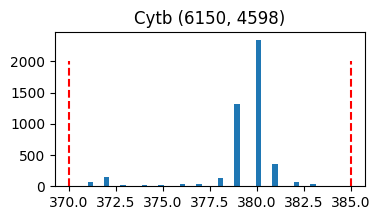

In [4]:
from Bio import SeqIO

gene = 'Cytb'
# for gene_fn in glob.glob('../../192/1data_derivation/nemu_input/*.fasta'):
gene_fn = f'../../192/1data_derivation/nemu_input/{gene}.fasta'
gene_seqs = list(SeqIO.parse(gene_fn, 'fasta'))
sizes = [len(x) for x in gene_seqs]
gene_seqs = [x for x in gene_seqs if len(x) > 370 and len(x) < 385]

plt.figure(figsize=(4, 2))
plt.hist([len(x) for x in gene_seqs], 45)
plt.vlines([370, 385], 0, 2000, 'r', '--')
plt.title(f'{gene} ({len(sizes)}, {len(gene_seqs)})')
plt.show()

In [5]:
from collections import Counter

obs_aa_freqs = []
for rec in gene_seqs:
    cur_cls = rec.description.split('###')[1].split(';')[1].split('_')[0]
    row = dict(Counter(rec.seq))
    row['cls'] = cur_cls
    row['len'] = len(rec)
    obs_aa_freqs.append(row)

obs_aa_freqs = pd.DataFrame(obs_aa_freqs).fillna(0)
del obs_aa_freqs['B']
del obs_aa_freqs['X']
obs_aa_freqs = obs_aa_freqs[obs_aa_freqs.cls.isin(obs_aa_freqs.cls.value_counts().head().index)].set_index('cls')
obs_aa_freqs = obs_aa_freqs.div(obs_aa_freqs['len'], axis=0)
del obs_aa_freqs['len']
obs_aa_freqs = obs_aa_freqs.melt(ignore_index=False, var_name='aa', value_name='freq').reset_index()
obs_aa_freqs['aa'] = obs_aa_freqs.aa.map(amino_acid_codes)
obs_aa_freqs

,cls,aa,freq
0,Actinopteri,Met,0.031579
1,Actinopteri,Met,0.036842
2,Mammalia,Met,0.031496
3,Mammalia,Met,0.034121
4,Actinopteri,Met,0.028947
...,...,...,...
89915,Aves,Glu,0.018421
89916,Aves,Glu,0.018421
89917,Aves,Glu,0.018421
89918,Aves,Glu,0.018421


In [7]:
obs_aa_freqs['cls'].value_counts()//20

cls
Mammalia        1727
Actinopteri     1630
Aves             551
Lepidosauria     371
Amphibia         217
Name: count, dtype: int64

<Axes: xlabel='aa', ylabel='freq'>

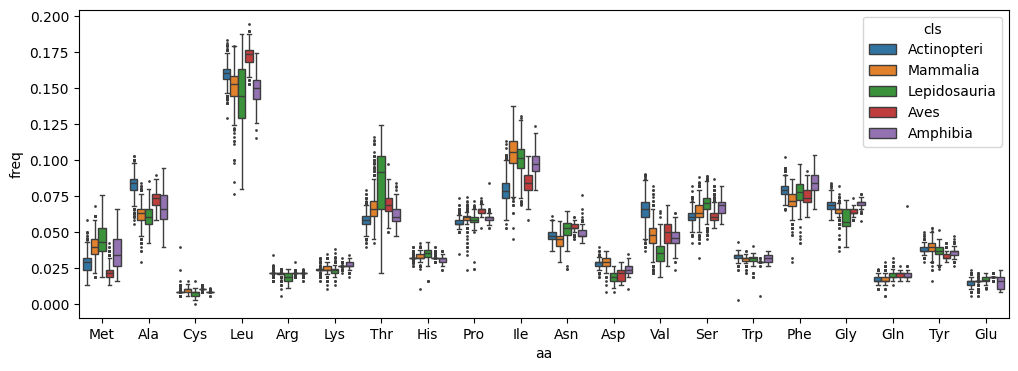

In [8]:
plt.figure(figsize=(12, 4))
sns.boxplot(data=obs_aa_freqs, x='aa', y='freq', hue='cls', showfliers=True, fliersize=1)

## Estimate equilibrium freqs

In [9]:
ms12 = pd.read_csv('../../192/1data_derivation/dataset/MutSpecVertebrates12.csv.gz')
ms12

,Gene,Class,Species,Mut,Observed,Expected,MutSpec
0,CO1,Mammalia,Crocuta_crocuta,A>C,NaN,115.066667,0.000000
1,CO1,Mammalia,Crocuta_crocuta,A>G,11.500444,173.333333,0.162818
2,CO1,Mammalia,Crocuta_crocuta,A>T,NaN,115.066667,0.000000
3,CO1,Mammalia,Crocuta_crocuta,C>A,NaN,71.466667,0.000000
4,CO1,Mammalia,Crocuta_crocuta,C>G,NaN,71.466667,0.000000
...,...,...,...,...,...,...,...
34387,CO3,Actinopteri,Cottus_gulosus,G>C,NaN,7.166667,0.000000
34388,CO3,Actinopteri,Cottus_gulosus,G>T,NaN,7.166667,0.000000
34389,CO3,Actinopteri,Cottus_gulosus,T>A,0.600700,32.500000,0.029888
34390,CO3,Actinopteri,Cottus_gulosus,T>C,1.384498,64.916667,0.034487


## Mean vertebrates spectra

In [101]:
mean_vert_ms12 = ms12[ms12.Gene == 'Cytb'].groupby(['Mut']).MutSpec.mean().to_dict()
df_changes = collect_possible_changes()

M = nuc_spectrum_to_matrix(mean_vert_ms12)
eq_prob = get_equilibrium_probabilities(M).astype(float)
nucl_eq = pd.Series(dict(zip(alphabet, eq_prob)))
nucl_eq.name = 'freq'
nucl_eq.index.name = 'nucl'
nucl_eq = nucl_eq.reset_index()
print(nucl_eq)


df_changes['rate'] = df_changes['sbs'].map(mean_vert_ms12)
cdn_sbs = df_changes.groupby(['cdn1', 'cdn2'])['rate'].sum()
M = cdn_spectrum_to_matrix(cdn_sbs)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs.name = 'freq'
eq_freqs.index.name = 'cdn'
eq_freqs = eq_freqs.reset_index()
eq_freqs['aa'] = eq_freqs['cdn'].map(coda.translate_codon).map(amino_acid_codes)
eq_freqs.to_csv('./data/vert_cdn_eq_freqs.csv', index=False)
print(eq_freqs)

  nucl      freq
0    A  0.430401
1    C  0.298899
2    G  0.083848
3    T  0.186852
    cdn      freq   aa
0   AAA  0.079730  Lys
1   AAC  0.055370  Asn
2   AAG  0.015532  Lys
3   AAT  0.034613  Asn
4   ACA  0.055370  Thr
..  ...       ...  ...
59  TGT  0.002927  Cys
60  TTA  0.015027  Leu
61  TTC  0.010436  Phe
62  TTG  0.002927  Leu
63  TTT  0.006524  Phe

[64 rows x 3 columns]


In [102]:
eq_freqs_aa_only = eq_freqs[eq_freqs.aa !='*'].groupby('aa')['freq'].sum()
eq_freqs_aa_only /= eq_freqs_aa_only.sum()
eq_freqs_aa_only = eq_freqs_aa_only.sort_values(ascending=False).reset_index()
eq_freqs_aa_only.to_csv('./data/vert_aa_eq_freqs.csv', index=False)
eq_freqs_aa_only

,aa,freq
0,Thr,0.136846
1,Lys,0.101334
2,Asn,0.095718
3,Pro,0.095035
4,Leu,0.078508
5,Ser,0.078056
6,Gln,0.070373
7,His,0.066473
8,Met,0.043992
9,Tyr,0.041554


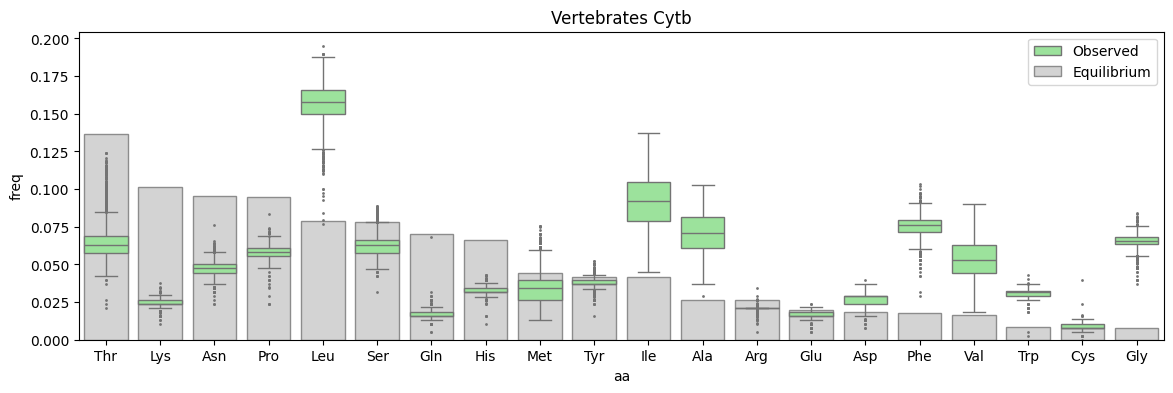

In [105]:
plt.figure(figsize=(14, 4))
ax = sns.barplot(eq_freqs_aa_only, x='aa', y='freq', color='lightgray', 
                 edgecolor=".55", label='Equilibrium')
sns.boxplot(data=obs_aa_freqs, x='aa', y='freq', showfliers=True, 
            fliersize=1, ax=ax, label='Observed', color='lightgreen')
ax.set_title('Vertebrates Cytb')
plt.savefig('./figures/aa_eq_freqs_vert_cytb.pdf')
plt.show()

Pearson Corr: 0.22


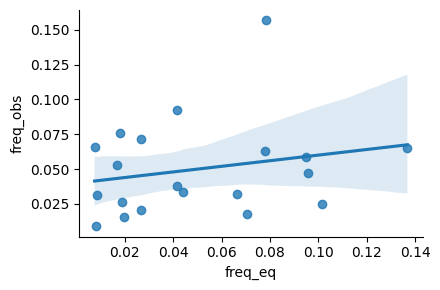

In [106]:
_ = eq_freqs_aa_only.merge(obs_aa_freqs.groupby('aa').freq.mean().reset_index(), 
                                on='aa', suffixes=('_eq', '_obs'))
print(f'Pearson Corr: {_.freq_eq.corr(_.freq_obs):.2f}')
sns.lmplot(data=_,x='freq_eq', y='freq_obs', fit_reg=True, height=3, aspect=1.5);

## Mean classes spectra

In [107]:
classes_spectra = ms12[ms12.Gene == 'Cytb'].groupby(['Class', 'Mut']).MutSpec.mean().unstack()
classes_spectra

Mut,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
Class,,,,,,,,,,,,
Actinopteri,0.014435,0.145561,0.013402,0.023053,0.012046,0.095308,0.461847,0.045048,0.017278,0.012928,0.147362,0.011732
Amphibia,0.013185,0.100753,0.019012,0.043678,0.003186,0.150426,0.457255,0.018041,0.019422,0.014543,0.150991,0.009507
Aves,0.008066,0.070300,0.007046,0.021095,0.004004,0.085040,0.464150,0.024109,0.006848,0.008436,0.297659,0.003249
Lepidosauria,0.011596,0.073535,0.012197,0.033103,0.004963,0.094936,0.534351,0.026590,0.026501,0.013173,0.159894,0.009161
Mammalia,0.006995,0.067613,0.012740,0.024510,0.005048,0.124436,0.480826,0.021098,0.019011,0.014834,0.216409,0.006481


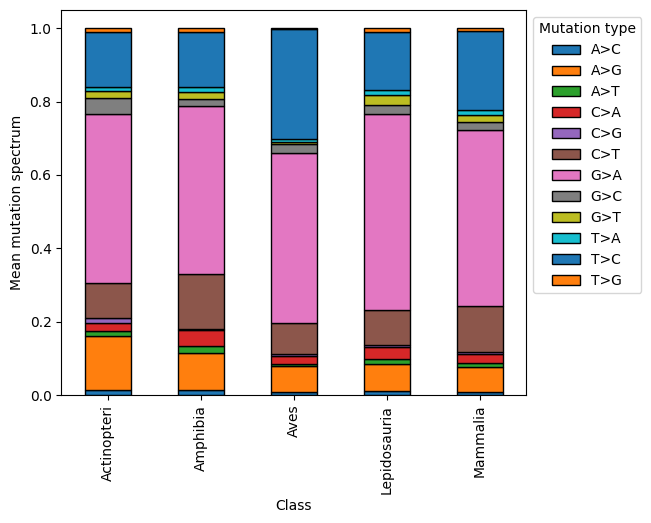

In [108]:
classes_spectra.plot(kind='bar', stacked=True, figsize=(6, 5), edgecolor='black')
plt.legend(title='Mutation type', bbox_to_anchor=(1, 1))
plt.ylabel('Mean mutation spectrum')
plt.show()

In [109]:
data_nucl = []
data_cdn = []

for _cls in classes_spectra.index:
    mean_cls_ms12 = classes_spectra.loc[_cls].to_dict()

    df_changes = collect_possible_changes()

    M = nuc_spectrum_to_matrix(mean_cls_ms12)
    eq_prob_nuc = get_equilibrium_probabilities(M).astype(float)
    nucl_eq = pd.Series(dict(zip(alphabet, eq_prob_nuc)))
    nucl_eq.name = 'freq'
    nucl_eq.index.name = 'nucl'
    nucl_eq = nucl_eq.reset_index().assign(cls=_cls)
    data_nucl.append(nucl_eq)


    df_changes['rate'] = df_changes['sbs'].map(mean_cls_ms12)
    cdn_sbs = df_changes.groupby(['cdn1', 'cdn2'])['rate'].sum()
    M = cdn_spectrum_to_matrix(cdn_sbs)
    eq_prob_cdn = get_equilibrium_probabilities(M).astype(float)

    eq_freqs = pd.Series(dict(zip(possible_codons, eq_prob_cdn)))
    eq_freqs.name = 'freq'
    eq_freqs.index.name = 'cdn'
    eq_freqs = eq_freqs.reset_index().assign(cls=_cls)
    eq_freqs['aa'] = eq_freqs['cdn'].map(coda.translate_codon).map(amino_acid_codes)
    data_cdn.append(eq_freqs)

In [110]:
df_cdn = pd.concat(data_cdn)
df_nucl = pd.concat(data_nucl)

df_aa_wide = df_cdn[df_cdn.aa !='*'].groupby(['cls', 'aa'])['freq'].sum().unstack()
df_aa_wide = (df_aa_wide.T / df_aa_wide.sum(1)).T
df_aa = df_aa_wide.stack().rename('freq').reset_index()

df_nucl.to_csv('./data/nucl_eq_freqs_cls.csv', index=False)
df_cdn.to_csv('./data/cdn_eq_freqs_cls.csv', index=False)
df_aa.to_csv('./data/aa_eq_freqs_cls.csv', index=False)

In [111]:
df_aa

,cls,aa,freq
0,Actinopteri,Ala,0.037339
1,Actinopteri,Arg,0.037339
2,Actinopteri,Asn,0.070308
3,Actinopteri,Asp,0.021973
4,Actinopteri,Cys,0.013541
...,...,...,...
95,Mammalia,Ser,0.068543
96,Mammalia,Thr,0.142229
97,Mammalia,Trp,0.006849
98,Mammalia,Tyr,0.041229


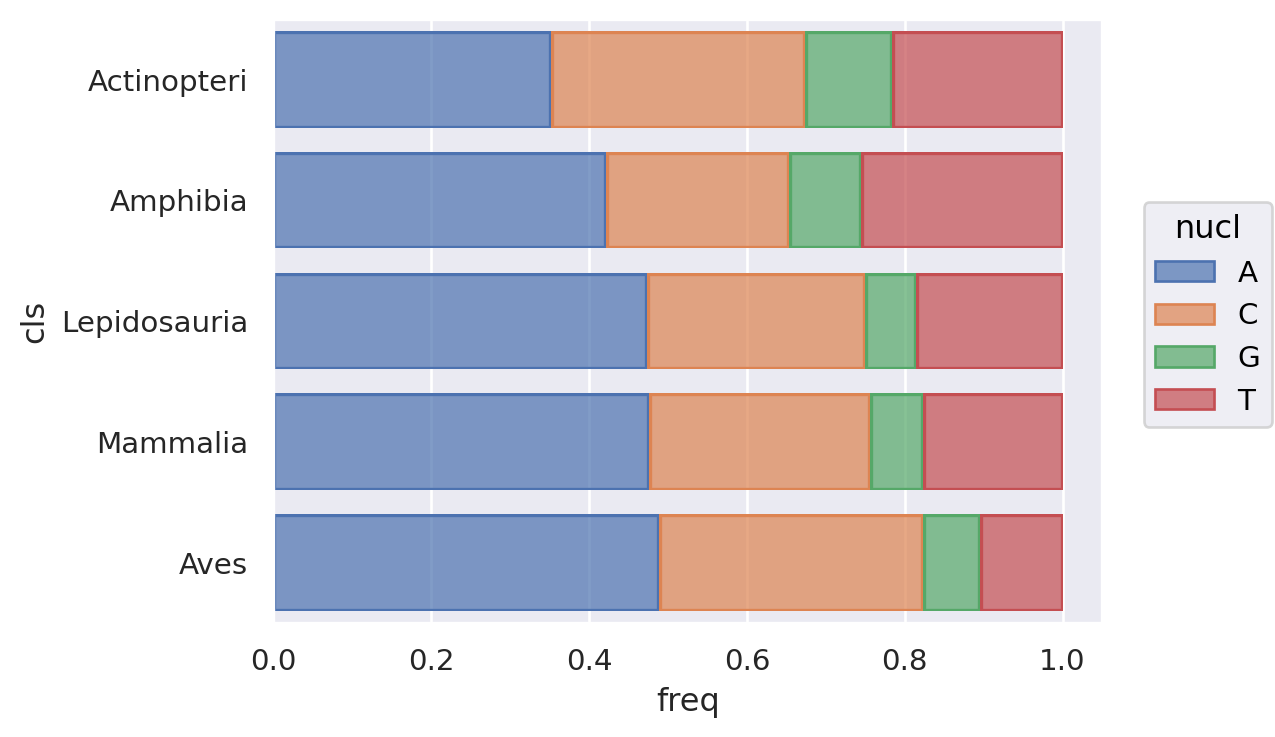

In [112]:
order=['Actinopteri', 'Amphibia', 'Lepidosauria', 'Mammalia', 'Aves']

so.Plot(df_nucl.set_index('cls').loc[order].reset_index(), 
        y="cls", x='freq', color="nucl"
).add(so.Bar(), so.Stack()).layout(size=(6,4)).save('figures/nuc_eq_freqs_cls.pdf')

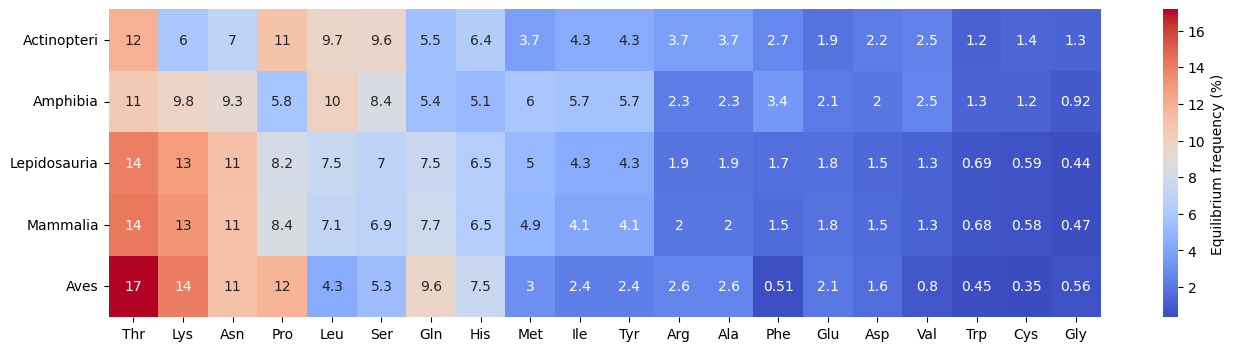

In [113]:
_ = df_aa.pivot(index='cls', columns='aa', values='freq').loc[order]*100

plt.figure(figsize=(16, 4))
sns.heatmap(_.loc[:,_.mean(0).sort_values(ascending=False).index], 
            cmap='coolwarm', annot=True, cbar_kws={'label': 'Equilibrium frequency (%)'})
plt.ylabel('')
plt.xlabel('')
plt.savefig('figures/aa_eq_freqs_cls_heatmap.pdf', bbox_inches='tight')
plt.show()

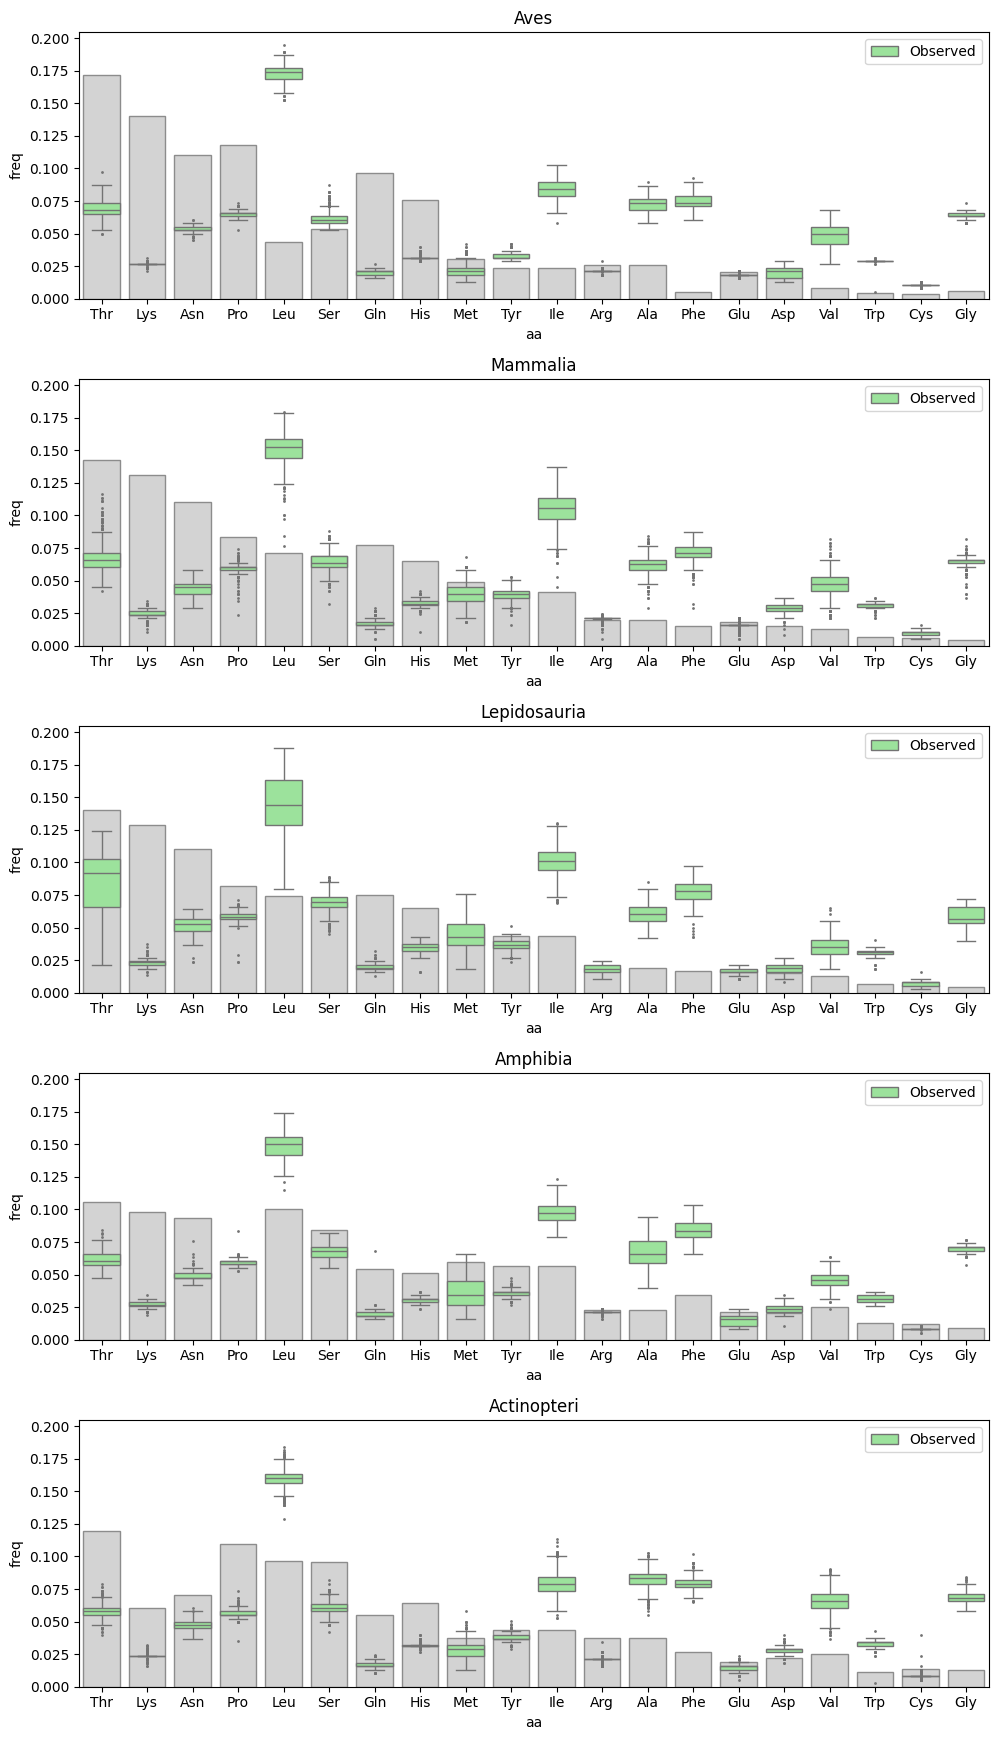

In [114]:
import warnings
warnings.filterwarnings("ignore")

order=['Actinopteri', 'Amphibia', 'Lepidosauria', 'Mammalia', 'Aves'][::-1]
_ = df_aa.pivot(index='cls', columns='aa', values='freq').loc[order]*100

# plt.figure(figsize=(10, 3.5))
fig, axs = plt.subplots(5, 1, figsize=(10, 3.5*5), sharey=True)
for i, _cls in enumerate(order):
    ax = sns.barplot(data=df_aa[df_aa.cls == _cls], x='aa', y='freq', 
                color='lightgray', edgecolor=".55", order=_.mean(0).sort_values(ascending=False).index, ax=axs[i])
    sns.boxplot(data=obs_aa_freqs[obs_aa_freqs.cls == _cls], x='aa', y='freq', showfliers=True,
                fliersize=1, ax=ax, label='Observed', color='lightgreen')
    
    ax.set_title(_cls)
plt.tight_layout()
plt.savefig('figures/aa_eq_obs_freqs_5cls.pdf', bbox_inches='tight')
plt.show()

pearsonr
Actinopteri: 0.36, p-value: 0.11
Amphibia: 0.40, p-value: 0.08
Lepidosauria: 0.29, p-value: 0.22
Mammalia: 0.15, p-value: 0.54
Aves: 0.06, p-value: 0.81


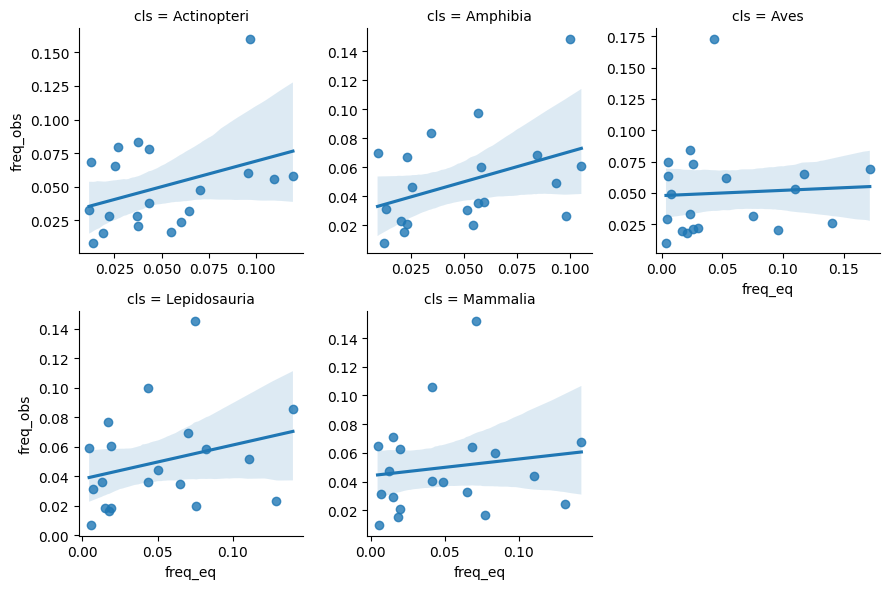

In [68]:
import scipy 

_ = df_aa.merge(obs_aa_freqs.groupby(['cls', 'aa']).freq.mean().reset_index(), 
                                on=['cls','aa'], suffixes=('_eq', '_obs'))
print('pearsonr')
for _cls in order[::-1]:
    res = scipy.stats.pearsonr(_.loc[_.cls == _cls].freq_eq, _.loc[_.cls == _cls].freq_obs)
    print(f'{_cls}: {res[0]:.2f}, p-value: {res[1]:.2f}')
g = sns.lmplot(data=_,x='freq_eq', y='freq_obs', col='cls', col_wrap=3, sharey=False, sharex=False,
           fit_reg=True, height=3, aspect=1)
g.savefig('figures/aa_eq_obs_freqs_5cls_lmplot.pdf', bbox_inches='tight')
plt.show()

### Determine gainers and loosers

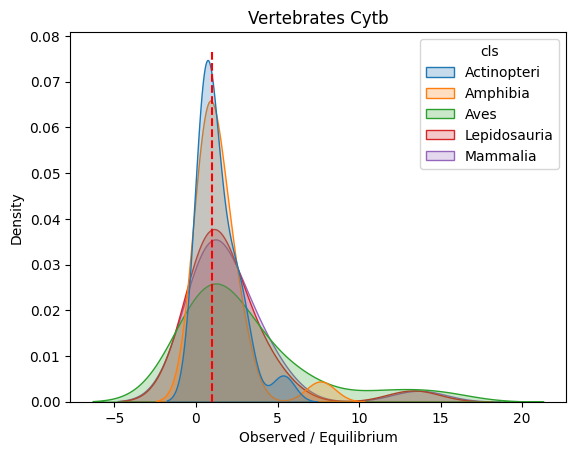

In [78]:
freq_div = obs_aa_freqs.groupby(['cls', 'aa']).freq.mean().reset_index()\
    .merge(df_aa, on=['cls', 'aa'], suffixes=('_obs', '_eq'))

freq_div['div'] = freq_div.freq_obs / freq_div.freq_eq
sns.kdeplot(freq_div, x='div', hue='cls', fill=True)
plt.vlines(1, 0, 0.077, 'r', '--', label='One')
plt.title('Vertebrates Cytb')
plt.xlabel('Observed / Equilibrium')
plt.show()

In [87]:
freq_div[freq_div.aa == 'Ser']

,cls,aa,freq_obs,freq_eq,div
15,Actinopteri,Ser,0.060054,0.095603,0.628164
35,Amphibia,Ser,0.068121,0.084364,0.807458
55,Aves,Ser,0.061743,0.053209,1.160377
75,Lepidosauria,Ser,0.069268,0.069878,0.991263
95,Mammalia,Ser,0.063894,0.068543,0.932171


In [83]:
freq_div.groupby('cls')['div'].quantile([0.25, 0.5, 0.75]).unstack()

,0.25,0.50,0.75
cls,,,
Actinopteri,0.549433,0.786067,1.913377
Amphibia,0.603254,0.863043,1.752509
Aves,0.535802,1.188326,3.678895
Lepidosauria,0.689277,0.980237,2.443782
Mammalia,0.658691,1.009387,2.706189


## Collect aa-substitutions from dataset of MBE

In [79]:
obs = pd.read_csv('/home/kpotoh/192/1data_derivation/dataset/obs_muts.csv')
obs['sbs12'] = obs.Mut.str.slice(2, 5)
obs['aa_sbs'] = obs['RefAa'].map() + '>' + obs['AltAa']
obs

,Mut,MutType,Site,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,...,AltNode,species,gene,class,edge_nobs,species_nobs,species_n_ts,is_ts,ts_frac,sbs12
0,A[C>T]C,1,54,3,AAC,AAT,N,N,0.301658,0.301658,...,Node2,Pica_pica,ND2,Aves,2.888788,55.307859,33,True,0.934426,C>T
1,A[T>C]T,1,57,3,CAT,CAC,H,H,0.317493,0.317493,...,Node2,Pica_pica,ND2,Aves,2.888788,55.307859,33,True,0.934426,T>C
2,T[T>C]A,2,63,3,GTT,GTC,V,V,0.316240,0.316240,...,Node2,Pica_pica,ND2,Aves,2.888788,55.307859,33,True,0.934426,T>C
3,C[C>T]C,2,132,3,CCC,CCT,P,P,0.303806,0.303806,...,Node2,Pica_pica,ND2,Aves,2.888788,55.307859,33,True,0.934426,C>T
4,T[T>C]G,2,141,3,GTT,GTC,V,V,0.315447,0.315447,...,Node2,Pica_pica,ND2,Aves,2.888788,55.307859,33,True,0.934426,T>C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202337,C[T>A]C,2,327,3,ACT,ACA,T,T,0.600700,0.600700,...,RN_9,Cottus_gulosus,CO3,Actinopteri,0.904790,27.985789,22,False,0.764706,T>A
202338,A[T>C]C,1,375,3,GAT,GAC,D,D,0.997170,0.997130,...,Node8,Cottus_gulosus,CO3,Actinopteri,0.997130,27.985789,22,True,0.764706,T>C
202339,A[G>A]T,1,114,3,CAG,CAA,Q,Q,0.997950,0.997950,...,RN_4,Cottus_gulosus,CO3,Actinopteri,0.997950,27.985789,22,True,0.764706,G>A
202340,C[A>G]A,2,312,3,GCA,GCG,A,A,1.000000,1.000000,...,RN_3,Cottus_gulosus,CO3,Actinopteri,1.000000,27.985789,22,True,0.764706,A>G


In [85]:
obs.MutType.value_counts()

2    107014
1     95328
Name: MutType, dtype: int64